# Summary

### Requirements:
    * Python 3.6
    * Pandas 0.23.4
    * Numpy 1.14.2
    * Scipy 1.1.0
    * Matplotlib 3.0.2
    * Basemap

### Processing:
    * Data Collecting: fetch .csv file from designated URL
    * Data Cleaning: Pandas conditional filters
    * Data Visualization: Matplotlibt + Basemap
    * Data Modeling: Scikit-learn (Random Forest + K-means)

### Hand craft functions:
    * Use [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute the distances based on Geographic coordinate system (longitude & latitude).
    * Determine nearest K-mean center, with vectorization to greatly speed up (comparing to the performance of for-loop).
   
### Findings:
    * Data Wrangling:
    1. One header, "Trip_type ", contained trailing white-space. Shouhld be "Trip_type" instead.
    2. Discrepancy in naming "lpep_pickup_datetime" vs "Lpep_dropoff_datetime; the latter used capital "L" while the former used lowercase "l".
        
    * Insights:
    1. No tip records for transactions paying in cash. (To be accurate, only 2 out of 770052 transactions.) This meant that, when building a tip prediction model, we have to rule out all the cash transactions. Otherwise you would acheive stunning high accuracy by predicting all cash transactions to have zero in tips.
    
    2. Total fair of transactions might be negative or zeros, due to disputes or unknown reasons. When deriving variable for tip percentage, these transactions have to be filtered out. Otherwise will encounter divided by zero error, or negative percentages.
    
    3. Some drivers were not charged based on taximeter, especially for those trips go/from JFK airport. Reasonable explaination was, drivers turned off taximeter once found out passengers' destination were JFK airport; 295 out of 2907 transactions had trip distance < 0.5, but with pick-up location farther than 0.5 miles away from JFK. Those transactions were labeled with RateCodeID = JFK, base fair amount = 52.0 rather than standard rate 4~6.
    
    4. 12,711 out of 1,469,735 transactions were originated/terminated at JFK (0.86%); 682 were originated/terminated at Newark (0.05%); 24663 were originated/terminated at LaGuardia (1.7%). Usually, local residents were more likely to either have their friends drive them, or drive by themselves to the airport, rather than calling a cab. We can assume most transactions that went/came from the airports were made by tourist. The number implied that, Boro taxis were not commonly used by tourists.
    
    5. According to the regulation, Boro cabs were not allowed to provide hail services at Manhattan downtown. This drastically reduced the chances for Boro cabs serving tourists. Based on this and the conclusion drawn from above (4th point), we can savely assume the majority Boro cab users were local residents.
    
    6. Based on that assumption, we concluded that there should exist certain patterns within the data, because most local residents would have regular routines and commute routes. We can go further and assume, during the morning 6-9AM, the "pick-up" locations could suggest where people actually lived; on the other hand, during the night 6-9PM, the "drop-off" locations would give us some hints about where the passenger might live at.

In [1]:
import os
import urllib
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Question 1
### Q: Programmatically download and load into your favorite analytical tool the trip data for September 2015.

In [2]:
if os.path.exists('./green_tripdata_2015-09.csv'):
    df = pd.read_csv('./green_tripdata_2015-09.csv')
else:
    source_url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
    df = pd.read_csv(url)
    df.to_csv('./green_tripdata_2015-09.csv')

### Q: Report how many rows and columns of data you have loaded.

In [3]:
r, c = df.shape
print('Contains {0} rows and {1} columns.'.format(r, c))
print()
print('--------Data Details----------')
df.info()

Contains 1494926 rows and 21 columns.

--------Data Details----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0

# Question 2
### Q: Plot a histogram of the number of the trip distance (“Trip Distance”).

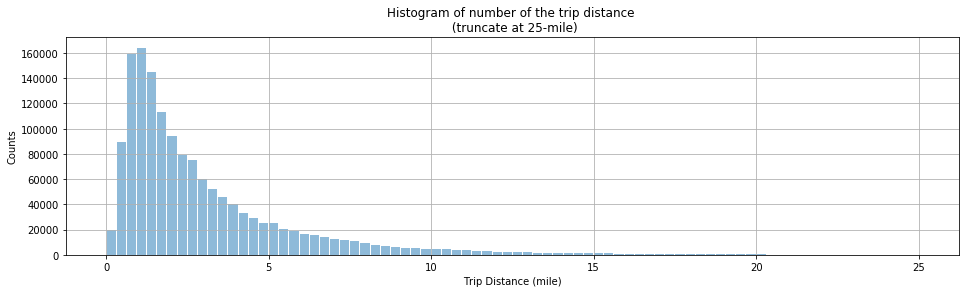

In [4]:
plt.figure(figsize=(16, 4));
plt.hist(x=df[df.Trip_distance >= 0.05].Trip_distance, range=(0, 25), bins=80, alpha=0.5, rwidth=0.9);
plt.xlabel('Trip Distance (mile)');
plt.ylabel('Counts');
plt.title('Histogram of number of the trip distance \n (truncate at 25-mile)');
plt.grid(True);

### Findings: 
* "Trip Distance" values are not always accurate.
* Drivers might not always charge based on meter readings.
* For example, 65+% of trips that go to or come from JFK airport have a ZERO Trip_distance.
* However, those data have a Total_amount roughly equal to the average cost of traveling to JFK.
* This indicates that we need to drop entries with Trip Distance = 0, cause the actual travel distance for those trips are definitely greater than zero.

### Conclusion:
* When deriving statistic values of Trip Distance, we have to get rid of rows that have Trip_distance = 0 but Total_amount > 10.

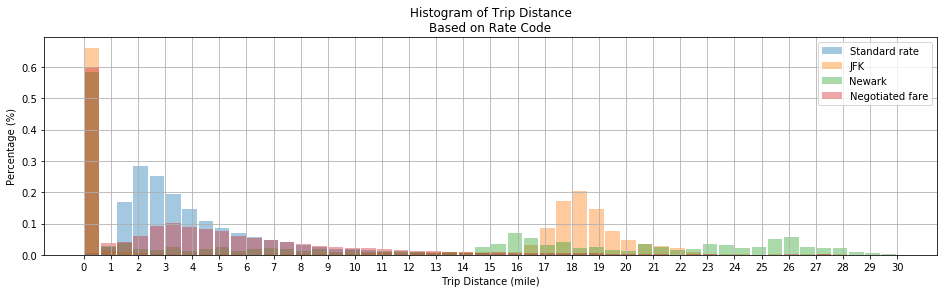

In [5]:
# Select rows that have RateCodeID == 2 (JFK) and the Total_amount > 10 (USD)
width = 0.3
plt.figure(figsize=(16, 4));
df[(df.RateCodeID == 1) & (df.Total_amount > 10.)].Trip_distance.hist(bins=50, alpha=0.4, range=(0, 30),
                                                                      rwidth=.9, density=True);
df[(df.RateCodeID == 2) & (df.Total_amount > 10.)].Trip_distance.hist(bins=50, alpha=0.4, range=(0, 30),
                                                                      rwidth=.9, density=True);
df[(df.RateCodeID == 3) & (df.Total_amount > 10.)].Trip_distance.hist(bins=50, alpha=0.4, range=(0, 30),
                                                                      rwidth=.9, density=True);
df[(df.RateCodeID == 5) & (df.Total_amount > 10.)].Trip_distance.hist(bins=50, alpha=0.4, range=(0, 30),
                                                                      rwidth=.9, density=True);
plt.xticks(range(31));
plt.xlabel('Trip Distance (mile)');
plt.ylabel('Percentage (%)');
plt.legend(['Standard rate', 'JFK', 'Newark', 'Negotiated fare']);
plt.title('Histogram of Trip Distance\nBased on Rate Code');
plt.grid(True);

#### Data Cleaning: Drop rows with Trip Distance < 0.05 (mile)

In [6]:
before_rows = df.shape[0]
df = df[df.Trip_distance > 0.05]
after_rows = df.shape[0]
print("Origin rows: {}\nCurrent rows: {}".format(before_rows, after_rows))
print("Remove {} rows ({:.2}%) of data.".format(before_rows-after_rows, (before_rows-after_rows)/before_rows*100.))

Origin rows: 1494926
Current rows: 1469736
Remove 25190 rows (1.7%) of data.


### Q: Report any structure you find and any hypotheses you have about that structure.

Log-normal distribution describes the underlying structure the best.

An aternative model is Gumbel distribution, which fits the peak better
but underestimates the occuring possibility for trips longer than 3 miles.


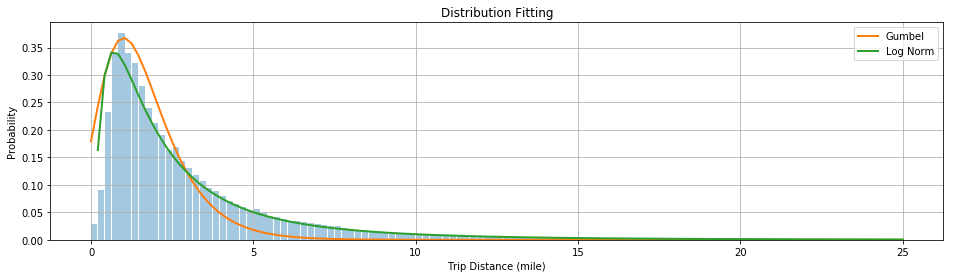

In [7]:
# the histogram of the data
plt.figure(figsize=(16, 4));
n, bins, patches = plt.hist(x=df.Trip_distance, 
                            range=(0, 25), 
                            bins=120, 
                            density=1, alpha=.4, rwidth=.9);
# Gumbel Distribution
_beta = 1.0
_mu = 1
z = (bins - _mu) / _beta
y = (1./_beta) * np.exp(-(z + np.exp(-z)))
plt.plot(bins, y, linewidth=2, label='Gumbel');

# LogNormal Distribution
_sigma = 1.0
_mu = 0.65
p = np.exp(-(np.log(bins[1:])-_mu)**2/(2.*_sigma**2)) / (bins[1:] * _sigma * (2*np.pi)**0.5)
plt.plot(bins[1:], p, linewidth=2, label='Log Norm');

print("Log-normal distribution describes the underlying structure the best.\n\n"
      "An aternative model is Gumbel distribution, which fits the peak better\n" 
      "but underestimates the occuring possibility for trips longer than 3 miles.")

plt.xlabel('Trip Distance (mile)');
plt.ylabel('Probability');
plt.title('Distribution Fitting');
plt.legend();
plt.grid(True);

# Question 3
### Q: Report mean and median trip distance grouped by hour of day.

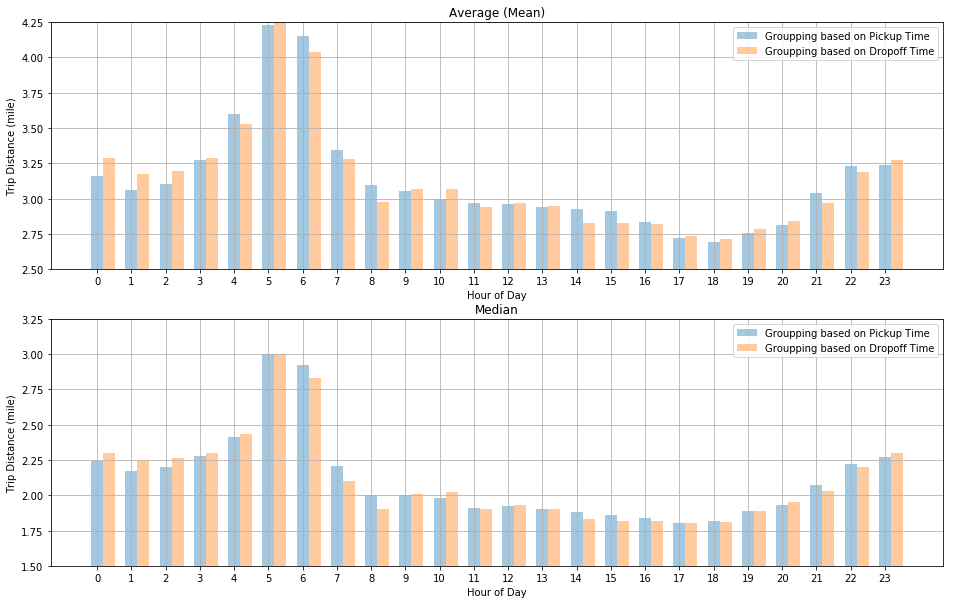

In [8]:
pickup_df = df.set_index(pd.DatetimeIndex(df['lpep_pickup_datetime']))
dropoff_df = df.set_index(pd.DatetimeIndex(df['Lpep_dropoff_datetime']))

# Group by "Pickup" time
pickup_mean = df.Trip_distance.groupby(pickup_df.index.hour).mean()
pickup_median = df.Trip_distance.groupby(pickup_df.index.hour).median()

# Group by "Dropoff" time
dropoff_mean = df.Trip_distance.groupby(dropoff_df.index.hour).mean()
dropoff_median = df.Trip_distance.groupby(dropoff_df.index.hour).median()

plt.figure(figsize=(16, 10));
plt.subplot(211);
plt.bar(pickup_mean.index, pickup_mean, width=0.35, alpha=0.4, label='Groupping based on Pickup Time');
plt.bar(dropoff_mean.index+0.35, dropoff_mean, width=0.35, alpha=0.4, label='Groupping based on Dropoff Time');
plt.xlabel('Hour of Day');
plt.ylabel('Trip Distance (mile)');
plt.title('Average (Mean)');
plt.ylim(2.5, 4.25);
plt.yticks(np.arange(2.5, 4.5, .25));
plt.xticks(range(24));
plt.legend();
plt.grid();

plt.subplot(212);
plt.bar(pickup_median.index, pickup_median, width=0.35, alpha=0.4, label='Groupping based on Pickup Time');
plt.bar(dropoff_median.index+0.35, dropoff_median, width=0.35, alpha=0.4, label='Groupping based on Dropoff Time');
plt.xlabel('Hour of Day');
plt.ylabel('Trip Distance (mile)');
plt.title('Median');
plt.ylim(1.5, 3.0);
plt.yticks(np.arange(1.5, 3.5, .25));
plt.xticks(range(24));
plt.legend();
plt.grid();

#### Findings:
* Average & median travel distance shared similar distribution.
* Reason that caused 5AM to reach a peak is because most of those transactions were going to JFK airport.
* Period between 5AM - 6AM actually had the least count of transactions.

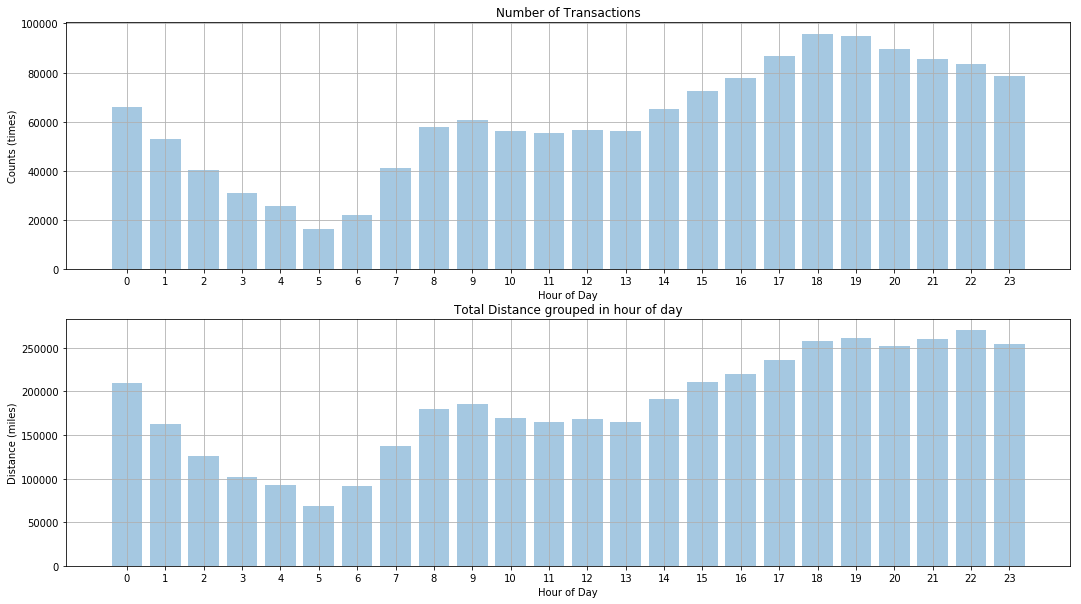

In [9]:
distance_count = df.Trip_distance.groupby(pickup_df.index.hour).count()
distance_sum = df.Trip_distance.groupby(pickup_df.index.hour).sum()
plt.figure(figsize=(18, 10));

plt.subplot(211);
plt.bar(range(24), distance_count, alpha=0.4);
plt.xticks(range(24));
plt.xlabel('Hour of Day');
plt.ylabel('Counts (times)');
plt.title('Number of Transactions');
plt.grid(True);

plt.subplot(212);
plt.bar(range(24), distance_sum, alpha=0.4);
plt.xticks(range(24));
plt.xlabel('Hour of Day');
plt.ylabel('Distance (miles)');
plt.title('Total Distance grouped in hour of day');
plt.grid(True);

### Q: We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. 
Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

#### Approach:
    * There are 3 airport to choose from: John F Kennedy (JFK), La Guardia (LGA), and Newark (EWR).
    * First, locate the coordinates of these 3 airports.
    * Compute the distance of each data entries with these airports.

#### Definition: 
    * If the pickup locations OR dropoff locations are within 1200 meters (~ 0.74 miles) radius from above 3 airports, then the transaction fitted into our criteria.

#### Results:
    * Originate or Terminate at [JFK]
      Trans. Counts:	12711
      Avg Fare:	48.72

    * Originate or Terminate at [Newark]
      Trans. Counts:	682
      Avg Fare:	97.89

    * Originate or Terminate at [LaGuardia]
      Trans. Counts:	24663
      Avg Fare:	24.83

In [10]:
def compute_dis(lons, lats, goal_lon, goal_lat):
    """Compute the distance on map (meter) between target coordinates.

    Args:
        lons (float|pandas.Series): a pd.Series of longitudes
        lats (float|pandas.Series): a pd.Series of latitudes
        goal_lon (float): target longitude 
        goal_lat (float): target latitude

    Return:
        distance (float|pandas.Series): a pd.Series of earth surface distance, unit in meters

    Formula Source:
        https://en.wikipedia.org/wiki/Haversine_formula
    """
    R = 6371.0E3
    theta_se = np.radians(lats)
    theta_goal = np.radians(goal_lat)
    delta_theta = np.radians(lats - goal_lat)
    delta_lambda = np.radians(lons - goal_lon)
    a = np.sin(delta_theta / 2.)**2 + np.cos(theta_se) * np.cos(theta_goal) * np.sin(delta_lambda / 2.)**2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    return R * c

In [11]:
radius = 1200
# Coordinate of JFK Airport
J_x, J_y = (-73.781301, 40.641714)

# Coordinate of Newark Airport
N_x, N_y = (-74.180256, 40.691126)

# Coordinate of LaGuardia Airport
L_x, L_y = (-73.872271, 40.775237)

df_near_JFK = df[(compute_dis(df.Pickup_longitude, df.Pickup_latitude, J_x, J_y) < radius) |
                    (compute_dis(df.Dropoff_longitude, df.Dropoff_latitude, J_x, J_y) < radius)]

df_near_NWK = df[(compute_dis(df.Pickup_longitude, df.Pickup_latitude, N_x, N_y) < radius) |
                    (compute_dis(df.Dropoff_longitude, df.Dropoff_latitude, N_x, N_y) < radius)]

df_near_LGD = df[(compute_dis(df.Pickup_longitude, df.Pickup_latitude, L_x, L_y) < radius) |
                    (compute_dis(df.Dropoff_longitude, df.Dropoff_latitude, L_x, L_y) < radius)]

print("Originate or Terminate at [JFK]")
print("Trans. Counts:\t{}\nAvg Fare:\t{:.4}".format(df_near_JFK.shape[0], df_near_JFK.Total_amount.mean()))
print()
print("Originate or Terminate at [Newark]")
print("Trans. Counts:\t{}\nAvg Fare:\t{:.4}".format(df_near_NWK.shape[0], df_near_NWK.Total_amount.mean()))
print()
print("Originate or Terminate at [LaGuardia]")
print("Trans. Counts:\t{}\nAvg Fare:\t{:.4}".format(df_near_LGD.shape[0], df_near_LGD.Total_amount.mean()))

Originate or Terminate at [JFK]
Trans. Counts:	12711
Avg Fare:	48.72

Originate or Terminate at [Newark]
Trans. Counts:	682
Avg Fare:	97.89

Originate or Terminate at [LaGuardia]
Trans. Counts:	24663
Avg Fare:	24.83


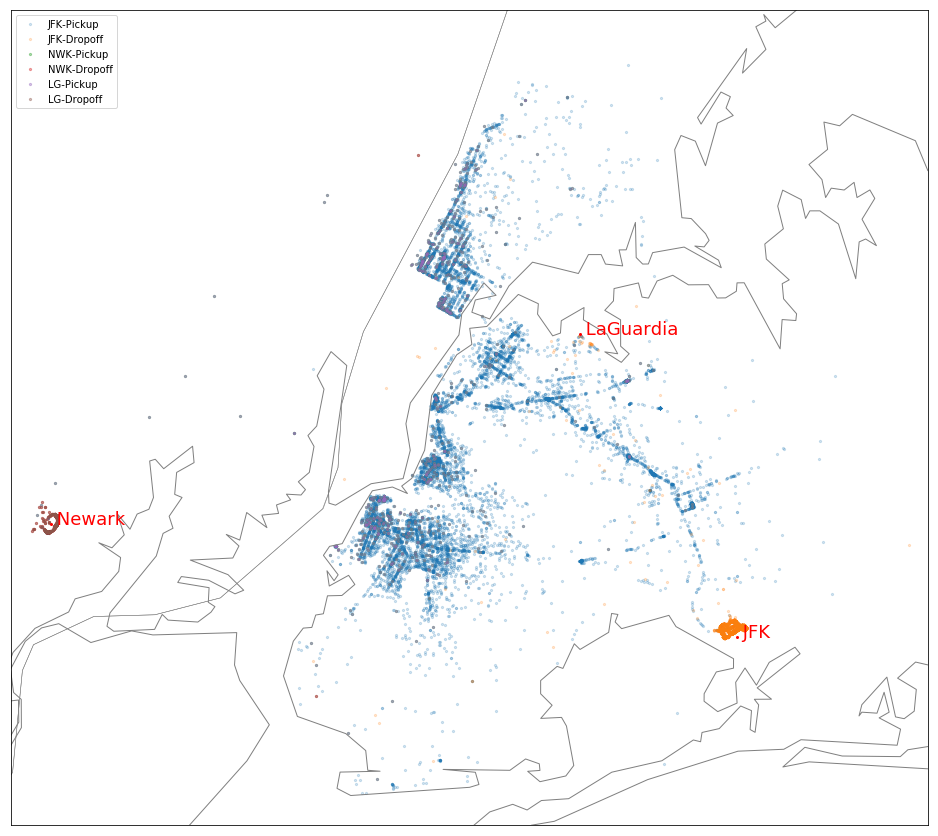

In [12]:
fig = plt.figure(figsize=(20, 15))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.738523, lon_0=-73.936873,
            width=4.5E4, height=4.0E4)

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=df_near_JFK.Pickup_longitude.values,
          y=df_near_JFK.Pickup_latitude.values,
          latlon=True, alpha=0.2, s=5, label='JFK-Pickup');
m.scatter(x=df_near_JFK.Dropoff_longitude.values,
          y=df_near_JFK.Dropoff_latitude.values,
          latlon=True, alpha=0.2, s=5, label='JFK-Dropoff');

m.scatter(x=df_near_NWK.Pickup_longitude.values,
          y=df_near_NWK.Pickup_latitude.values,
          latlon=True, alpha=0.4, s=5, label='NWK-Pickup');
m.scatter(x=df_near_NWK.Dropoff_longitude.values,
          y=df_near_NWK.Dropoff_latitude.values,
          latlon=True, alpha=0.4, s=5, label='NWK-Dropoff');

m.scatter(x=df_near_NWK.Pickup_longitude.values,
          y=df_near_NWK.Pickup_latitude.values,
          latlon=True, alpha=0.4, s=5, label='LG-Pickup');
m.scatter(x=df_near_NWK.Dropoff_longitude.values,
          y=df_near_NWK.Dropoff_latitude.values,
          latlon=True, alpha=0.4, s=5, label='LG-Dropoff');

# Coordinate for JFK
x, y = m(J_x, J_y)
plt.plot(x, y, 'or', markersize=2)
plt.text(x, y, ' JFK', fontsize=18, color='red');

# Coordinate for Newark
x, y = m(N_x, N_y)
plt.plot(x, y, 'or', markersize=2)
plt.text(x, y, ' Newark', fontsize=18, color='red');

# Coordinate for LaGuardia
x, y = m(L_x, L_y)
plt.plot(x, y, 'or', markersize=2)
plt.text(x, y, ' LaGuardia', fontsize=18, color='red');

plt.legend(loc='upper left');

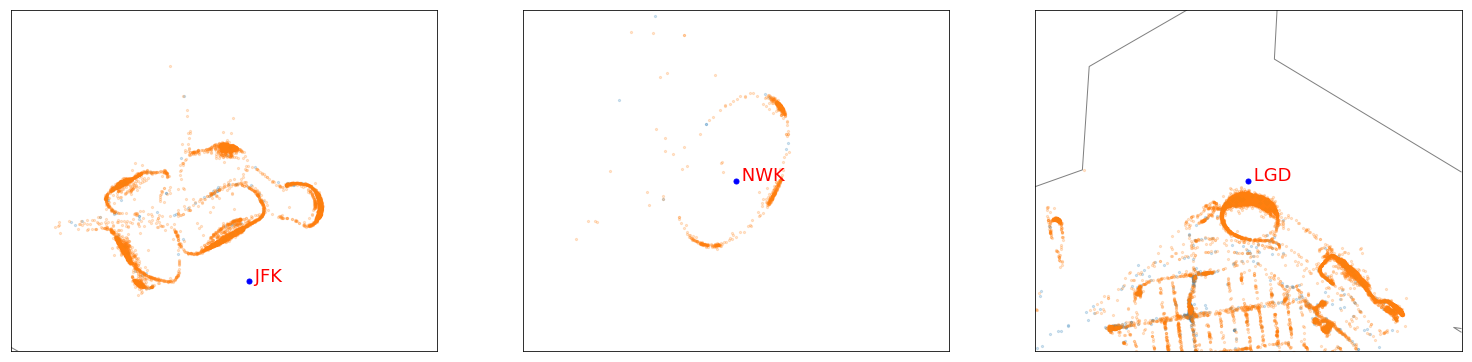

In [13]:
plt.figure(figsize=(26, 12));

# JFK
plt.subplot(131);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.647, lon_0=-73.783,
            width=2.5E3, height=2.0E3)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=df_near_JFK.Pickup_longitude.values,
          y=df_near_JFK.Pickup_latitude.values,
          latlon=True, alpha=0.2, s=5);
m.scatter(x=df_near_JFK.Dropoff_longitude.values,
          y=df_near_JFK.Dropoff_latitude.values,
          latlon=True, alpha=0.2, s=5);

x, y = m(J_x, J_y)
plt.plot(x, y, 'ob', markersize=5);
plt.text(x, y, ' JFK', fontsize=18, color='red');


# NWK
plt.subplot(132);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=N_y, lon_0=N_x,
            width=2.5E3, height=2.0E3)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=df_near_NWK.Pickup_longitude.values,
          y=df_near_NWK.Pickup_latitude.values,
          latlon=True, alpha=0.2, s=5);
m.scatter(x=df_near_NWK.Dropoff_longitude.values,
          y=df_near_NWK.Dropoff_latitude.values,
          latlon=True, alpha=0.2, s=5);

x, y = m(N_x, N_y)
plt.plot(x, y, 'ob', markersize=5);
plt.text(x, y, ' NWK', fontsize=18, color='red');

# LGD
plt.subplot(133);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=L_y, lon_0=L_x,
            width=2.5E3, height=2.0E3)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=df_near_LGD.Pickup_longitude.values,
          y=df_near_LGD.Pickup_latitude.values,
          latlon=True, alpha=0.2, s=5);
m.scatter(x=df_near_LGD.Dropoff_longitude.values,
          y=df_near_LGD.Dropoff_latitude.values,
          latlon=True, alpha=0.2, s=5);

x, y = m(L_x, L_y)
plt.plot(x, y, 'ob', markersize=5);
plt.text(x, y, ' LGD', fontsize=18, color='red');

# Question 4
### Q: Build a derived variable for tip as a percentage of the total fare.

#### Findings:
    * Rides paid with cash did not have tip records.
    * Over 770052 transactions with cash payment, only 2 transactions had tip numbers reported.

#### Conclusion:
    * It's not because people didn't tip when paying in cash, it's because drivers wouldn't (or couldn't) report every tip they'd received.
    * Since tip records were available only for credit card transactions, I looked only at trips paid for by credit card.

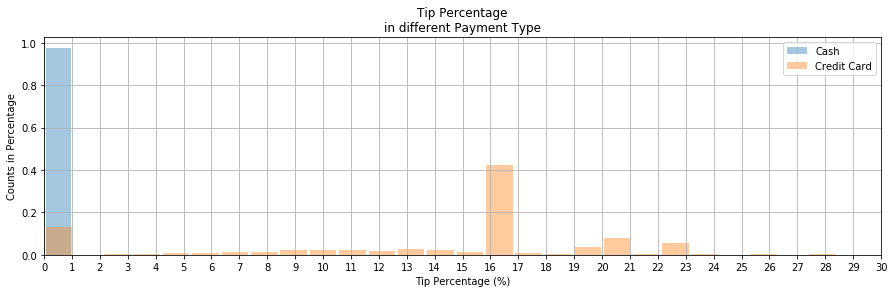

In [14]:
tip_percentage_cash = df[(df.Payment_type == 2) & (df.Total_amount != 0)].Tip_amount / \
                        df[(df.Payment_type == 2) & (df.Total_amount != 0)].Total_amount * 100.0
tip_percentage_credit = df[(df.Payment_type == 1) & (df.Total_amount != 0)].Tip_amount / \
                            df[(df.Payment_type == 1) & (df.Total_amount != 0)].Total_amount * 100.0

plt.figure(figsize=(15, 4));
tip_percentage_cash.hist(bins=95, alpha=0.4, rwidth=0.9, density=True);
tip_percentage_credit.hist(bins=95, alpha=0.4, rwidth=0.9, density=True);
plt.xlim(0, 30);
plt.xticks(range(31));
plt.xlabel('Tip Percentage (%)');
plt.ylabel('Counts in Percentage');
plt.title('Tip Percentage\nin different Payment Type');
plt.legend(['Cash', 'Credit Card']);

### Q: Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). 
Provide an estimate of performance using an appropriate sample, and show your work.

#### Step 1:
* Use Random Forest to quickly determine the importance of features.
* Training _X_ includes all the columns of original data, and "duration" derived from subtracting pick-up time & drop-off time.
* Training _y_ is the tip percentage.
* Only select transactions with credit card payment. (Cause no tip records for cash transactions.)

#### Step 1 Results:
Top 5 dominant features:

    1. Dropoff_latitude          23.42%
    2. Pickup_longitude          18.74%
    3. Dropoff_longitude         16.88%
    4. Pickup_latitude           15.24%
    5. Duration                  14.81%

#### Step 1 Conclusions:
* Location, location, location: locations where people got on & off cars were correlated to tip percentages.
* Duration of each trip would affect tip percentages.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
feature_list = ['RateCodeID',
                'Pickup_longitude',
                'Pickup_latitude',
                'Dropoff_longitude',
                'Dropoff_latitude',
                'Passenger_count',
                'improvement_surcharge',
                'Trip_type ',
                'Duration',
                'Day',
                'Hour',
                'Minute']

pickup_time = pd.to_datetime(df['lpep_pickup_datetime'])
# Duration is the time difference between pick-up time & drop-off time
duration = pd.to_datetime(df.Lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)
df['Duration'] = duration.dt.seconds

# Convert Date-time string to numerical numbers
df['Day'] = pickup_time.dt.day
df['Hour'] = pickup_time.dt.hour
df['Minute'] = pickup_time.dt.minute

# Select transactions with Payment_type == 1 (Credit card)
# Select transactions with df.Total_amount != 0, preventing divided by zero error
valid_tip = df[(df.Payment_type == 1) & (df.Total_amount != 0)].Tip_amount
valid_total = df[(df.Payment_type == 1) & (df.Total_amount != 0)].Total_amount
tip_continuous = valid_tip / valid_total * 100.0

# Convert continues Tip Percentage into discrete groups
tip_discrete = tip_continuous.copy()
tip_discrete[tip_continuous > 20] = 22
tip_discrete[(tip_continuous > 15) & (tip_continuous <= 20)] = 17
tip_discrete[(tip_continuous > 10) & (tip_continuous <= 15)] = 13
tip_discrete[(tip_continuous > 1) & (tip_continuous <= 10)] = 7
tip_discrete[tip_continuous <= 1] = 0
df['Tip'] = tip_discrete

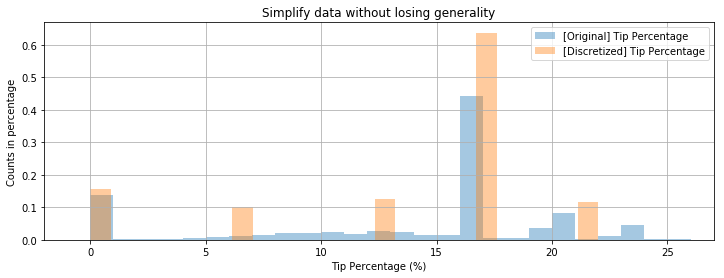

In [17]:
plt.figure(figsize=(12, 4));
plt.hist(tip_continuous, bins=100, alpha=0.4, label='[Original] Tip Percentage', density=True);
plt.hist(tip_discrete, bins=25, alpha=0.4, label='[Discretized] Tip Percentage', density=True);
plt.xticks(range(0, 26, 5));
plt.xlim(-2, 27);
plt.xticks(range(0, 26, 5));
plt.xlabel('Tip Percentage (%)');
plt.ylabel('Counts in percentage');
plt.legend();
plt.title('Simplify data without losing generality');
plt.grid(True);

In [18]:
X = df[(df.Payment_type == 1) & (df.Total_amount != 0)].loc[:, feature_list]
y = tip_discrete

# Split the training & testing samples with ratio 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [19]:
clf = RandomForestClassifier(n_estimators=20, max_depth=10, bootstrap=True, random_state=0)
clf.fit(X_train, y_train)
print('Mean accuracy on the given test data: {}'.format(clf.score(X_test, y_test)))
print()
print("Feature\tImportance")
print("-------------------")
for i, importance in enumerate(clf.feature_importances_):
    print("{:25}{:6.2f}".format(feature_list[i], importance*100))

Mean accuracy on the given test data: 0.5675282889266476

Feature	Importance
-------------------
RateCodeID                 2.40
Pickup_longitude          18.74
Pickup_latitude           15.24
Dropoff_longitude         16.88
Dropoff_latitude          23.42
Passenger_count            0.49
improvement_surcharge      1.10
Trip_type                  2.10
Duration                  14.81
Day                        1.28
Hour                       2.20
Minute                     1.33


#### Step 2:
* Because locations where people got off & on had direct correlation with tip percentages,
* Use K-means to cluster tip percentages based on coordinates.
* Select only transactions located within 20 km (12.43 miles) radius from center coordinate (longitude: -73.882235, latitude: 40.747555), because K-means is sensitive to outliers.

#### Step 2 Results:
* Classifying based on geographical locations was a good starting point. Geographical data were easy to visualize, which allowed me to quick identify possible issue with my model, and to incorporate knowledge from other disciplines.
* Final model grouped data into 20 categories (regions).
* The grouping results matched with original tip percentage distributions.
* If given with more time, I attempt to use Mixture Gaussian model for more smooth border transitions.

In [20]:
from sklearn.cluster import KMeans

In [21]:
def find_closest_center(longs, lats, center_longs, center_lats, center_tiprates):
    """Return the index of closest K-mean centers
    """
    center_num = len(center_longs)
    expanding_longs = np.array([j for i in longs for j in [i] * center_num])
    expanding_lats = np.array([j for i in lats for j in [i] * center_num])
    
    sample_num = len(longs)
    expanding_center_longs = np.array(center_longs * sample_num)
    expanding_center_lats = np.array(center_lats * sample_num)
    
    dis_sq = (expanding_longs - expanding_center_longs)**2 + (expanding_lats - expanding_center_lats)**2
    return [center_tiprates[i] for i in dis_sq.reshape(sample_num, center_num).argmin(axis=1)]

In [22]:
feature_list = ['Dropoff_longitude', 'Dropoff_latitude', 'Tip']
dis_dropoff = compute_dis(df.Dropoff_longitude, df.Dropoff_latitude, -73.882235, 40.747555)
X_dropoff = df[(df.Payment_type == 1) & (df.Total_amount != 0) & (dis_dropoff < 20000)].loc[:, feature_list]

scaler = StandardScaler()
scaler.fit(X_dropoff)
s = scaler.transform(X_dropoff)
kmeans = KMeans(n_clusters=20, random_state=0).fit(s)

In [23]:
# Make prediction based on locations
# Each transaction was assigned to its closest K-mean center.
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cen_x, cen_y, cen_tip = list(zip(*centers))
predicts = find_closest_center(X_dropoff.Dropoff_longitude, X_dropoff.Dropoff_latitude, cen_x, cen_y, cen_tip)

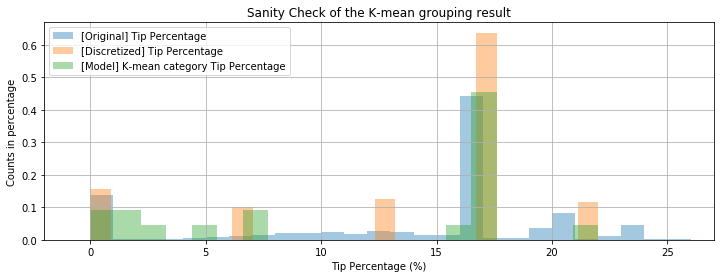

In [24]:
plt.figure(figsize=(12, 4));
plt.hist(tip_continuous, bins=100, alpha=0.4, label='[Original] Tip Percentage', density=True);
plt.hist(tip_discrete, bins=25, alpha=0.4, label='[Discretized] Tip Percentage', density=True);
plt.hist(cen_tip, bins=20, alpha=0.4, label='[Model] K-mean category Tip Percentage', density=True);
plt.xticks(range(0, 26, 5));
plt.xlim(-2, 27);
plt.xticks(range(0, 26, 5));
plt.legend();
plt.xlabel('Tip Percentage (%)');
plt.ylabel('Counts in percentage');
plt.title('Sanity Check of the K-mean grouping result');
plt.grid(True);

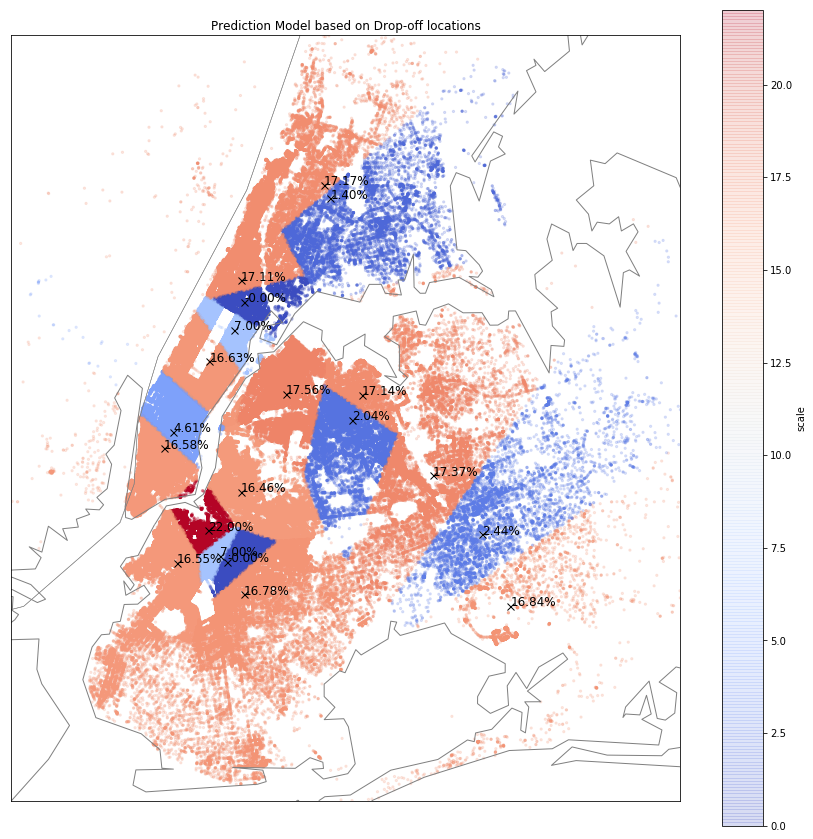

In [25]:
plt.figure(figsize=(15, 15));
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=3.5E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=X_dropoff.Dropoff_longitude.values,
          y=X_dropoff.Dropoff_latitude.values,
          c=predicts, cmap='coolwarm',
          latlon=True, alpha=0.2, s=5);

for center in scaler.inverse_transform(kmeans.cluster_centers_):
    c_x, c_y, c_t = center
    x, y = m(c_x, c_y)
    plt.plot(x, y, 'xk', markersize=7)
    plt.text(x, y, '{:3.2f}%'.format(c_t), fontsize=12, color='k');
    
plt.title('Prediction Model based on Drop-off locations');
plt.colorbar(label='scale');

#### Extra Findings: Compare with NYC's housing prices
* Neighbors with lower median housing prices tend to tip less than 5%.
* However, higher housing prices did not guarantee a higher tip percentage.
* (caveats: since I could not find the housing prices for 2015, the housing statistics here were based on 2018.

<img src="./img/housing_price_2018.png">
<center>Source: https://www.trulia.com/real_estate/New_York-New_York/ </center>

#### Extra Findings: Compare with NYC's Crime map
* Frequency of crime cases (Manhattan South Percinct, Bronx, lower part of Queens) roughly matched with low tip regions.
* For regions with lower than 17 crimes/1000 residents, the correlation with tips did not exist.
* (caveats: since I could not find the housing prices for 2015, the crime data here were based on entire 2017.

<img src="./img/crime_map_2017.png">
<center>Source: https://maps.nyc.gov/crime/</center>

# Question 5

### Option B: Visualization
Q: Can you build a visualization (interactive or static) of the trip data that helps us understand intra- vs. inter-borough traffic? What story does it tell about how New Yorkers use their green taxis?

#### Goal: Find out tip percentage for all rides originating in a neighborhood.
* But how to determine where did passengers live at? "Pickup" locations or "Dropoff" locations?
* Since Robo Taxis were not allowed to provide hail services at Manhattan downtown area, we could presume most passengers taking Robo cabs were residents of NYC.
* Assume during morning 6AM - 9AM, the "Pick up" locations were more likely to be where they lived.
* Assume during evening 5PM - 8PM, the "Drop off" locations were more likely to be where people lived.
* Assume during midnight 23PM - 2AM, the "Drop off" locations were more likely to be where people lived.

In [26]:
# Note: Difference between df & pickup_df is
# pickup_df uses "lpep_pickup_datetime" as index.

work_time = df[(pickup_df.index.hour > 6) & (pickup_df.index.hour < 9)]
home_time = df[(pickup_df.index.hour > 17) & (pickup_df.index.hour < 20)]
midnight_time = df[(pickup_df.index.hour > 23) | (pickup_df.index.hour < 2)]

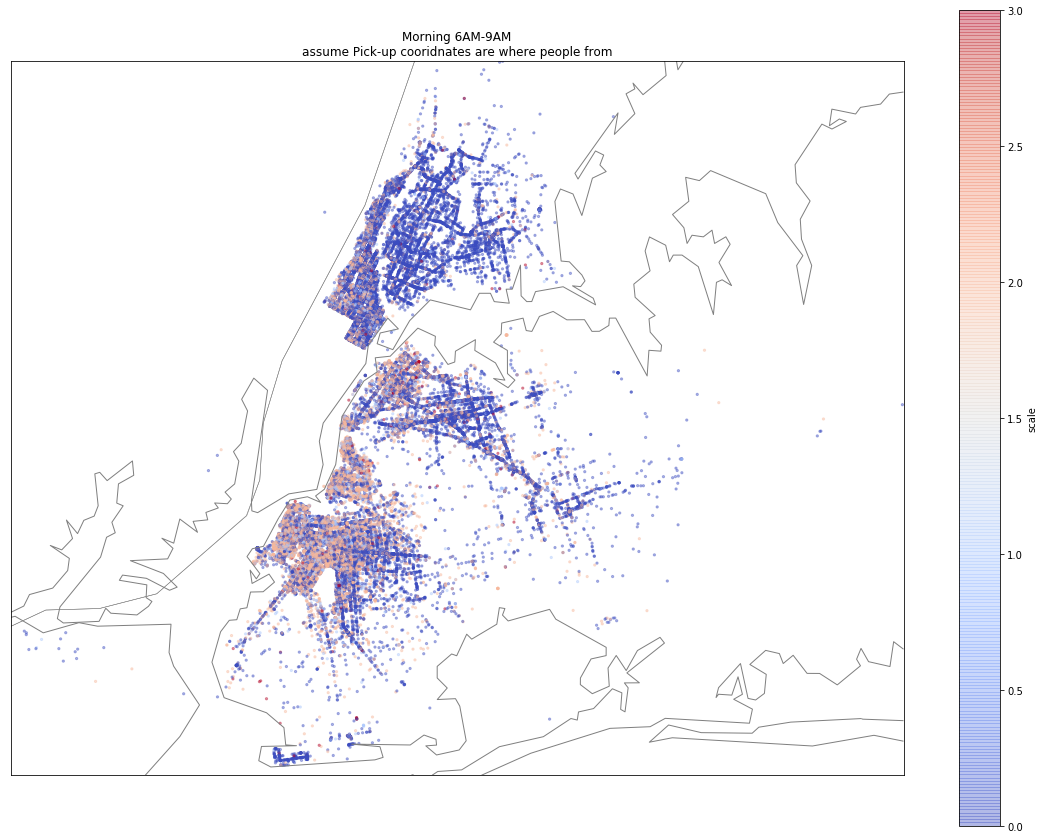

In [27]:
tip_grouping = work_time.Tip_amount / work_time.Total_amount * 100.
tip_grouping[tip_grouping <= 5] = 0
tip_grouping[(5 < tip_grouping) & (tip_grouping <= 15)] = 1
tip_grouping[(15 < tip_grouping) & (tip_grouping <= 25)] = 2
tip_grouping[(25 < tip_grouping)] = 3

plt.figure(figsize=(20, 15));
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=work_time.Pickup_longitude.values,
          y=work_time.Pickup_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Morning 6AM-9AM\nassume Pick-up cooridnates are where people from');
plt.colorbar(label='scale');

    In the above diagram, every dots represented were people got ON Robo cabs during 6AM - 9AM, and the color of the dots indicated the tip percentage for that trip. Most people from Bronx paid 0% tips.

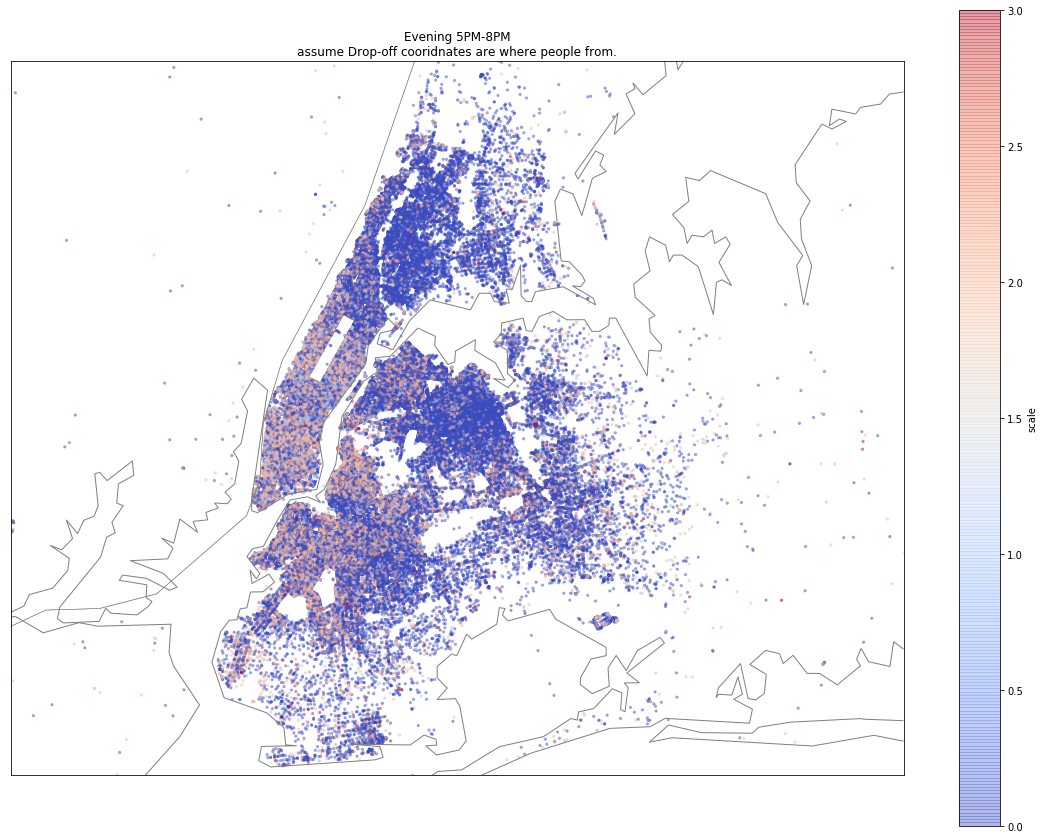

In [28]:
tip_grouping = home_time.Tip_amount / home_time.Total_amount * 100.
tip_grouping[tip_grouping <= 5] = 0
tip_grouping[(5 < tip_grouping) & (tip_grouping <= 15)] = 1
tip_grouping[(15 < tip_grouping) & (tip_grouping <= 25)] = 2
tip_grouping[(25 < tip_grouping)] = 3

plt.figure(figsize=(20, 15));
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=home_time.Dropoff_longitude.values,
          y=home_time.Dropoff_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Evening 5PM-8PM\nassume Drop-off cooridnates are where people from.');
plt.colorbar(label='scale');

    In the above diagram, every dots represented were people got OFF Robo cabs during 5PM - 8PM, and the color of the dots indicated the tip percentage for that trip. Compared with the morning diagram, one would notice that Boro cabs picked up passengers mostly on the main streets, resulting a more concentrated graph that mapped out the contours of all the main streets.

#### Findings:
    * People from Bronx paid the least tips among other region.
    * Upper Brooklyn paid the most tips in general.
    * High fraction of travels during 5AM - 6AM were going to JFK.

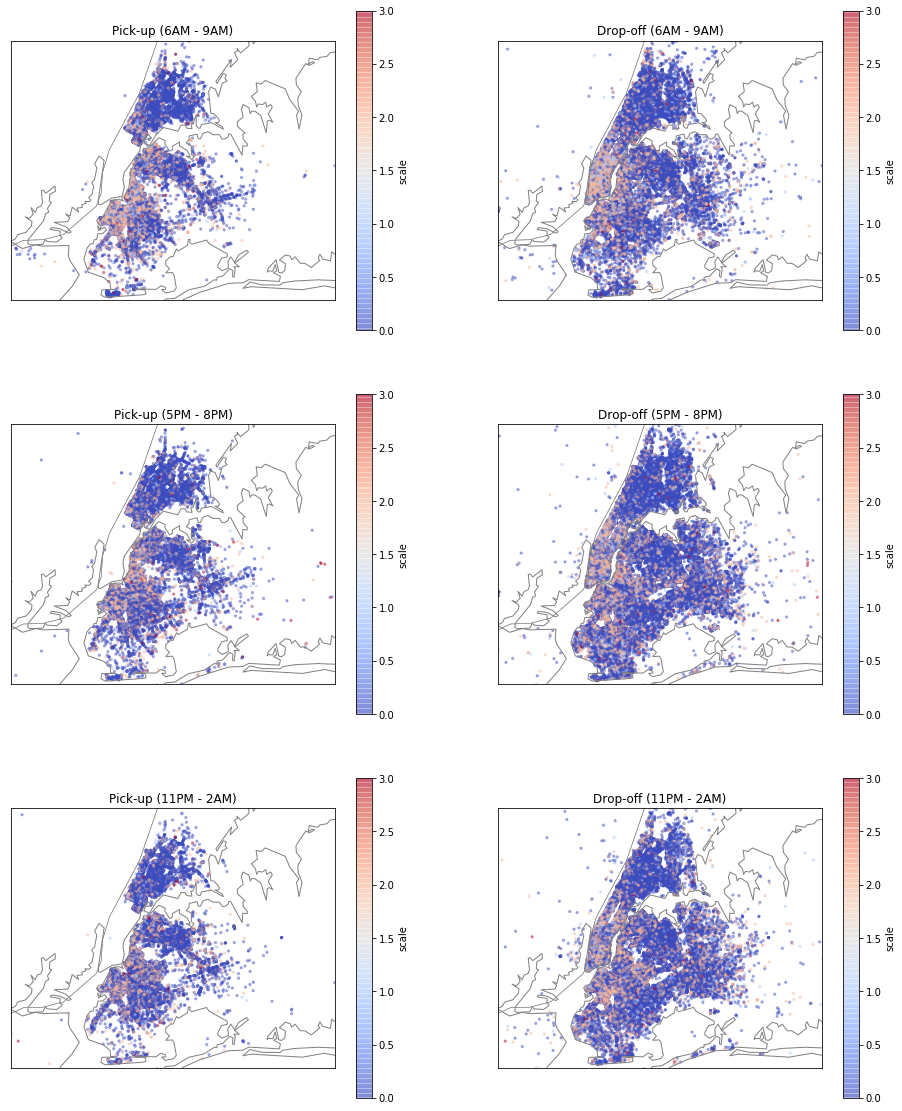

In [29]:
tip_grouping = work_time.Tip_amount / work_time.Total_amount * 100.
tip_grouping[tip_grouping <= 5] = 0
tip_grouping[(5 < tip_grouping) & (tip_grouping <= 15)] = 1
tip_grouping[(15 < tip_grouping) & (tip_grouping <= 25)] = 2
tip_grouping[(25 < tip_grouping)] = 3

plt.figure(figsize=(16, 20));
plt.subplot(321);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=work_time.Pickup_longitude.values,
          y=work_time.Pickup_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Pick-up (6AM - 9AM)');
plt.colorbar(label='scale');


plt.subplot(322);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=work_time.Dropoff_longitude.values,
          y=work_time.Dropoff_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Drop-off (6AM - 9AM)');
plt.colorbar(label='scale');

tip_grouping = home_time.Tip_amount / home_time.Total_amount * 100.
tip_grouping[tip_grouping <= 5] = 0
tip_grouping[(5 < tip_grouping) & (tip_grouping <= 15)] = 1
tip_grouping[(15 < tip_grouping) & (tip_grouping <= 25)] = 2
tip_grouping[(25 < tip_grouping)] = 3

plt.subplot(323);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=home_time.Pickup_longitude.values,
          y=home_time.Pickup_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Pick-up (5PM - 8PM)');
plt.colorbar(label='scale');


plt.subplot(324);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=home_time.Dropoff_longitude.values,
          y=home_time.Dropoff_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Drop-off (5PM - 8PM)');
plt.colorbar(label='scale');

tip_grouping = midnight_time.Tip_amount / midnight_time.Total_amount * 100.
tip_grouping[tip_grouping <= 5] = 0
tip_grouping[(5 < tip_grouping) & (tip_grouping <= 15)] = 1
tip_grouping[(15 < tip_grouping) & (tip_grouping <= 25)] = 2
tip_grouping[(25 < tip_grouping)] = 3

plt.subplot(325);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=midnight_time.Pickup_longitude.values,
          y=midnight_time.Pickup_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Pick-up (11PM - 2AM)');
plt.colorbar(label='scale');


plt.subplot(326);
m = Basemap(projection='lcc', resolution='h', 
            lat_0=40.747555, lon_0=-73.882235,
            width=5.0E4, height=4.0E4);

m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(x=midnight_time.Dropoff_longitude.values,
          y=midnight_time.Dropoff_latitude.values,
          c=tip_grouping, cmap='coolwarm',
          latlon=True, alpha=0.4, s=5);
plt.title('Drop-off (11PM - 2AM)');
plt.colorbar(label='scale');

#### Findings:

Assume our previous assumptions hold true:

    * Most people are not tourists; they commuted between regions regularly.
    * During 6AM - 9PM, "Pick up" locations were where people lived.
    * During 5PM - 8PM, "Drop off" locations were where people lived.
    * During 11PM - 2AM, "Drop off" locations were where people lived.
    * Most importantly, people behaved consistently; if they tipped 20% in the morning rides, we assumed he/she would remain roughly the same during the night.

Then we can derive some important relationships that would help us identify same group of people:

    * Morning pick-up red dots can be mapped to evening drop-off red dots; and same rules applies to blue dots.
    * A fraction of people worked at Manhattan downtown were lived in Brooklyn (Based on the moving of red dots).
    * Drop-off 5PM-8PM shown a similar distribution as Drop-off 11PM-2AM. Was expecting 5PM-8PM might contain too much noise, but turned out it did perform consistently with the distribution during 11PM-2AM.
    * People tended to take longer distance during the night.
    * Travel distance had no significant correlation with tip percentages.
    * Try to catch a Robo taxi during 11PM would probably a bad idea.